In [2]:
import scanpy as sc
#import gseapy as gs
import numpy as np
import scipy as sp
from scipy.stats import spearmanr, pearsonr, wilcoxon, mannwhitneyu

import pandas as pd

# Importing plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import DivergingNorm
from matplotlib import cm

sns.set_style('white')
sns.set_style('ticks', {'font.family': 'FreeSans'})

# Scanpy settings
sc.settings.verbosity = 3            # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

celltype = 'cd8'
master_dir = '../'

scanpy==1.6.0 anndata==0.7.5 umap==0.4.6 numpy==1.19.4 scipy==1.5.4 pandas==1.1.4 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3


In [3]:
adata_metab = sc.read_h5ad(master_dir + 'output/' + celltype + '-processed-analyzed-metab.h5ad')
adata_metab

AnnData object with n_obs × n_vars = 25966 × 1387
    obs: 'patient', 'ICU_status', 'IL6i_between_draws', 'no_IL6i', 'WHO_scale', 'Blood_draw_time', 'Sex', 'Age_at_baseline', 'Days_since_onset_of_symptoms', 'louvain', 'Days_since_onset_float', 'umap_density_ICU_status'
    uns: 'ICU_status_colors', 'louvain', 'louvain_colors', 'neighbors', 'patient_colors', 'pca', 'rank_genes_groups', 'umap', 'umap_density_ICU_status_params'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [4]:
# Also read in the flow data summary
flow = pd.read_excel(master_dir + 'data/flow/data for Jihoon and Yapeng_updated.xlsx', 
                     sheet_name='cd8 HK2 comparison')
flow['T cell panel'] = flow['T cell panel'].str.replace('INCOV', '').str.lstrip('0')
flow.head(10)

,T cell panel,flow_%KI67+CD8+,10x cd8 leiden8,flow cd8 count
0,20-1,0.63,0.000000,2221
1,22-2,1.53,0.835655,1241
2,31-2,2.50,1.176471,1442
3,32-2,1.16,1.333333,5763
4,33-2,1.89,0.988468,6771
5,34-2,0.42,0.793651,10271
6,69-2,1.62,1.049869,5239
7,79-2,1.73,9.090909,1507
8,87-1,0.54,1.239669,6242
9,88-1,1.35,0.500000,6428


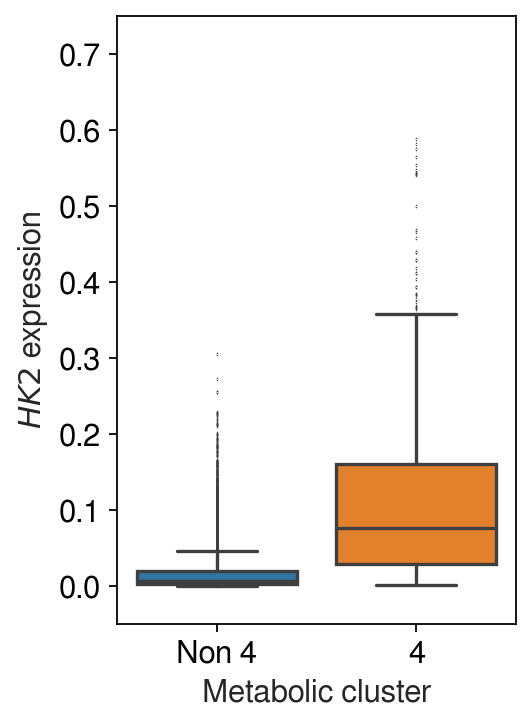

In [5]:
a = pd.DataFrame(adata_metab[adata_metab.obs['louvain']!='4'].X[:, 
                                                np.where(adata_metab.var_names=='HK2')].flatten())
a['louvain'] = 'Non 4'
b = pd.DataFrame(adata_metab[adata_metab.obs['louvain']=='4'].X[:, 
                                                np.where(adata_metab.var_names=='HK2')].flatten())
b['louvain'] = '4'
a = pd.concat([a, b])

plt.figure(figsize=(3.2, 5))
sns.boxplot(data=a, x='louvain', y=0, fliersize=0.01)
plt.ylabel(r'$\itHK2$ expression')
plt.ylim([-0.05, 0.75])
plt.xlabel('Metabolic cluster')
plt.grid(False)
plt.savefig(master_dir + 'output/flow/cd8-metab-cluster-4_HK2-comparison.pdf')

In [6]:
mannwhitneyu(a[a['louvain']=='Non 4'][0], a[a['louvain']=='4'][0])

MannwhitneyuResult(statistic=2790237.0, pvalue=0.0)

In [7]:
# Also read in the flow data summary
flow_flow = pd.read_excel(master_dir + 'data/flow/data for Jihoon and Yapeng_updated.xlsx', 
                     sheet_name='cd8 HK2')
#flow_flow['T cell panel'] = flow_flow['T cell panel'].str.replace('INCOV', '').str.lstrip('0')
flow_flow.head(10)

,Unnamed: 0,HK2 fluorescence values of KI67+ CD8s,HK2 fluorescence values of KI67- CD8s
0,INCOV020-1,3310.3,2109.7
1,INCOV022-2,4035.9,2315.0
2,INCOV031-2,2805.4,2451.1
3,INCOV032-2,2493.6,1966.3
4,INCOV033-2,2976.7,1890.7
5,INCOV034-2,2641.0,1771.5
6,INCOV069-2,2586.2,1914.5
7,INCOV079-2,3242.5,2347.8
8,INCOV087-1,3355.4,2171.3
9,INCOV088-1,3250.9,2065.8


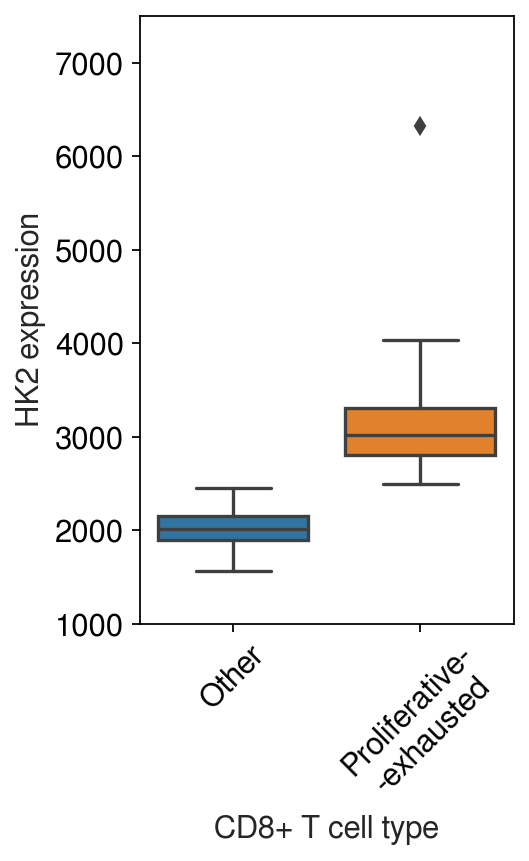

In [9]:
a = flow_flow.iloc[:, [2, 1]].values.flatten()
plt.figure(figsize=(3, 5))
fig = sns.boxplot(x=['Non-proliferative', 'Proliferative'] * len(flow_flow),
            y=a)
plt.ylabel('HK2 expression')
plt.ylim([1000, 7500])
fig.set_xticklabels(['Other', 'Proliferative-\n-exhausted'],
                   rotation=45)
plt.xlabel('CD8+ T cell type')
plt.grid(False)
plt.savefig(master_dir + 'output/flow/cd8-flow-cluster_HK2-comparison.pdf')

In [10]:
mannwhitneyu(flow_flow.iloc[:, 1], flow_flow.iloc[:, 2])

MannwhitneyuResult(statistic=0.0, pvalue=3.7339217844353662e-06)

### Correlations between flow data and 10X data

Need to use the full current 10X dataset to account for new patients

In [2]:
adata_full = sc.read_h5ad(master_dir + 'data/PBMC_processed/flow_comparisons/cd8_t_cells_gex_imputed.h5ad')
adata_full

AnnData object with n_obs × n_vars = 152381 × 25711
    obs: 'batch_info', 'batch', 'subbatch', 'sample', 'patient', 'status', 'cell_groups', 'B7-H4', 'CD10', 'CD101_BB27', 'CD103_Integrin-AE', 'CD106', 'CD107A_LAMP-1', 'CD112_NECTIN-2', 'CD117_c-Kit', 'CD11A', 'CD11B', 'CD11C', 'CD122_IL-2RB', 'CD123', 'CD124_IL-4RA', 'CD127_IL-7RA', 'CD133', 'CD137L_4-1BB_Ligand', 'CD137_4-1BB', 'CD138_Syndecan-1', 'CD14-1', 'CD141_Thrombomodulin', 'CD144_VE-Cadherin', 'CD146', 'CD150_SLAM', 'CD152_CTLA-4', 'CD154', 'CD155_PVR', 'CD158B_KIR2DL2-L3_NKAT3', 'CD158E1_KIR3DL1_NKB1', 'CD158F_KIR2DL5', 'CD158_KIR2DL1-S1-S3-S5', 'CD15_SSEA-1', 'CD16', 'CD161', 'CD163-1', 'CD169_Sialoadhesin_Siglec-1', 'CD178_FAS-L', 'CD18', 'CD183_CXCR3', 'CD184_CXCR4', 'CD185_CXCR5', 'CD19-1', 'CD193_CCR3', 'CD194_CCR4', 'CD195_CCR5', 'CD196_CCR6', 'CD197_CCR7', 'CD1A-1', 'CD1C-1', 'CD1D-1', 'CD2-1', 'CD20', 'CD204', 'CD206_MMR', 'CD207-1', 'CD209_DC-SIGN', 'CD21', 'CD22-1', 'CD223_LAG-3', 'CD224', 'CD226_DNAM-1', 'CD23', 

In [3]:
len(adata_full.obs['sample'].unique())

375

In [10]:
# How many sick vs. healthy patients
len(adata_full.obs[adata_full.obs['sample'].str.contains('-')]['sample'].unique())

359

In [7]:
adata_full.obs.head()

,batch_info,batch,subbatch,sample,patient,status,cell_groups,B7-H4,CD10,CD101_BB27,...,TCR-VB13.1,TCR-VD2,TCR-VG9,TIGIT_VSTM3,TSLPR_CRL2,Tau_Phospho_Thr181,XCR1-1,c-Met,leiden,phenotype
AAACCTGAGATGTAAC-1-1:Mix:Mix_donor1,1:Mix:Mix_donor1,1,Mix,Mix_donor1,Mix_donor1,Healthy,T-cells,8.445087,7.752155,9.623593,...,9.255898,0.000000,8.668188,7.752155,0.000000,0.000000,7.752155,7.059438,0,Naive
AAACCTGAGGGCTTGA-1-1:Mix:Mix_donor1,1:Mix:Mix_donor1,1,Mix,Mix_donor1,Mix_donor1,Healthy,T-cells,8.763677,7.952941,7.952941,...,8.869021,6.567701,8.763677,8.964318,8.512406,7.952941,9.205453,8.645913,10,Naive
AAACCTGCATGGGACA-1-1:Mix:Mix_donor1,1:Mix:Mix_donor1,1,Mix,Mix_donor1,Mix_donor1,Healthy,T-cells,9.208776,7.417517,7.417517,...,9.026474,0.000000,8.110363,7.417517,7.417517,0.000000,9.026474,0.000000,0,Naive
AAAGCAAGTAAACGCG-1-1:Mix:Mix_donor1,1:Mix:Mix_donor1,1,Mix,Mix_donor1,Mix_donor1,Healthy,T-cells,8.361849,7.263703,9.971100,...,9.209013,0.000000,7.263703,7.956501,8.110601,6.858589,8.110601,7.263703,10,Naive
AAAGTAGGTCGGGTCT-1-1:Mix:Mix_donor1,1:Mix:Mix_donor1,1,Mix,Mix_donor1,Mix_donor1,Healthy,T-cells,8.217359,0.000000,10.209556,...,9.198019,0.000000,8.910371,8.217359,8.504973,8.217359,8.910371,8.217359,0,Naive


In [8]:
# Loading in metabolics-relevant pathways from KEGG (based on Xiao et al. Nat Commun 2019)
# Genes in each KEGG pathway
metab_genes = pd.read_csv(master_dir + 'data/KEGG_genesets/hsa00001.metab.keg.gmt', 
                          sep='\t', header=None)
metab_genes.index = metab_genes.iloc[:, 0]
metab_genes = metab_genes.drop([0], axis=1)

metab_pathway_list = metab_genes.index

# Get a flat array of metabolism-related genes
metab_gene_list = np.array(metab_genes.iloc[:, 1:]).flatten().astype(str)
metab_gene_list = metab_gene_list[metab_gene_list != 'nan']

# Make a new data object with only the metabolic genes from the KEGG pathways
metab_gene_list_overlap = list(set(metab_gene_list).intersection(set(adata_full.var_names)))
adata_metab = adata_full[:, metab_gene_list_overlap]

# Convert the metabolic pathways dataframe into a dictionary for GSEA
metab_genes_dict = metab_genes.transpose().to_dict(orient='series')
for element in metab_genes_dict:
    # Only include the genes that are also found in the single cell sequencing
    metab_genes_dict[element] = list(set(metab_genes_dict[element]).intersection(set(adata_full.var_names)))

In [9]:
sc.tl.pca(adata_metab, svd_solver='arpack')
sc.pp.neighbors(adata_metab)
sc.tl.umap(adata_metab)
sc.tl.louvain(adata_metab, resolution=0.1)

computing PCA
    with n_comps=50
    finished (0:00:42)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:03:26)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:55)


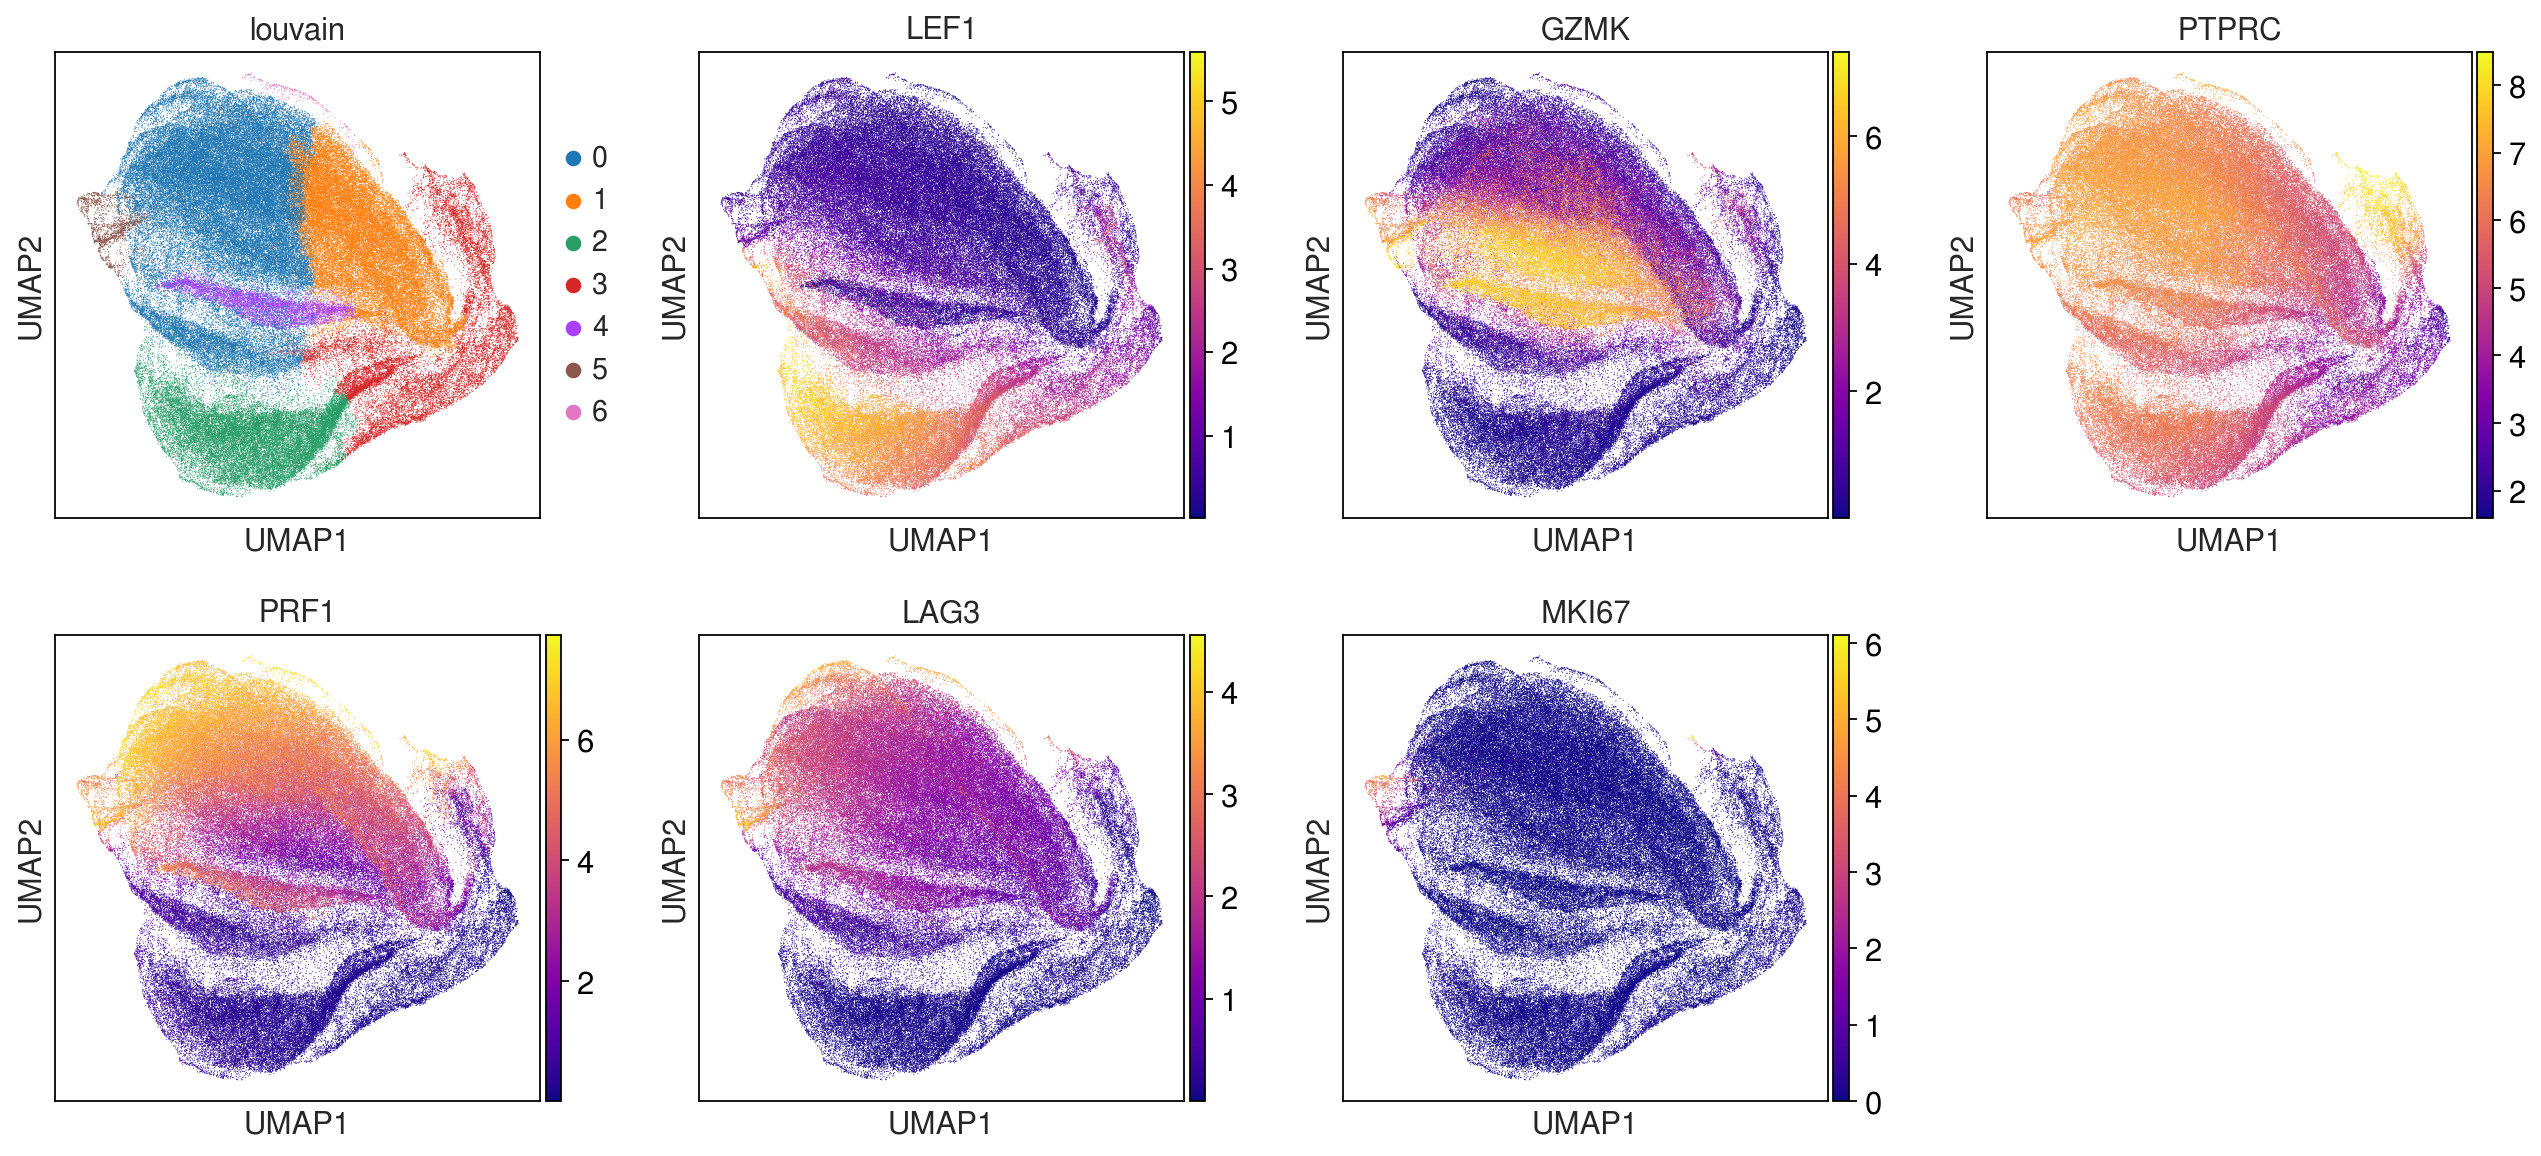

In [10]:
adata_metab_all_genes = adata_full.copy()
adata_metab_all_genes.obs = adata_metab.obs.copy()
adata_metab_all_genes.uns = adata_metab.uns.copy()
adata_metab_all_genes.obsm = adata_metab.obsm.copy()
fig = sc.pl.umap(adata_metab_all_genes, color=['louvain', 'LEF1', 'GZMK',
                        'PTPRC', 'PRF1', 'LAG3', 'MKI67'], cmap='plasma', use_raw=False)

In [122]:
gex = adata_metab.obs.groupby('sample')['louvain'].value_counts(normalize=True).unstack().fillna(0)

In [169]:
flow_vs_gex = pd.merge(flow.set_index('T cell panel'), gex.loc[:, '5'], 
                       left_index=True, right_index=True, how='inner')
flow_vs_gex['5'] *= 100
# Drop outliers
flow_vs_gex = flow_vs_gex[flow_vs_gex['flow cd8 count'] > 2000]
flow_vs_gex = flow_vs_gex[flow_vs_gex['5'] < 5]

In [170]:
flow_vs_gex

,flow_%KI67+CD8+,10x cd8 leiden8,flow cd8 count,5
20-1,0.630,0.000000,2221,0.884956
32-2,1.160,1.333333,5763,1.315789
33-2,1.890,0.988468,6771,2.521008
34-2,0.420,0.793651,10271,0.270270
69-2,1.620,1.049869,5239,2.977233
87-1,0.540,1.239669,6242,1.666667
88-1,1.350,0.500000,6428,1.515152
92-2,0.091,0.917431,7699,0.913242
129-2,0.083,0.000000,6005,0.000000
109-2,1.660,3.389831,4637,1.724138


(-0.1, 2.0)

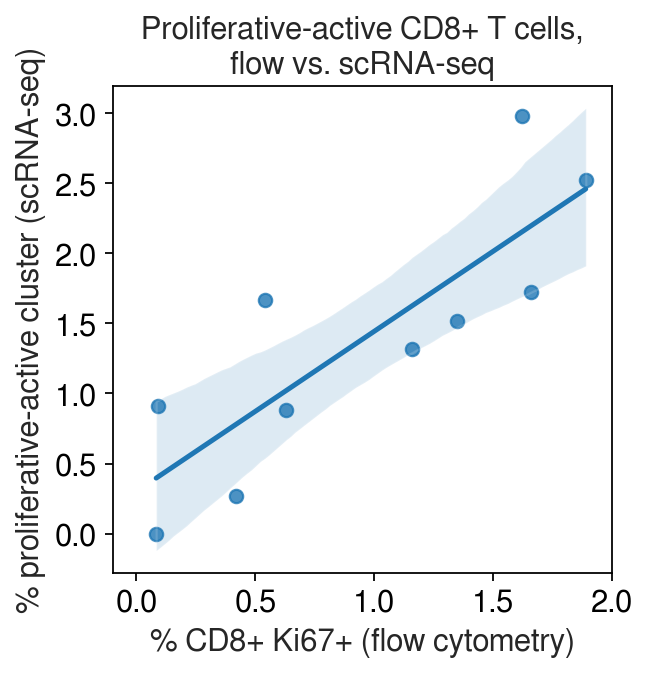

In [171]:
sns.regplot(data=flow_vs_gex, x='flow_%KI67+CD8+', y='5')
plt.ylabel('% proliferative-active cluster (scRNA-seq)')
plt.xlabel('% CD8+ Ki67+ (flow cytometry)')
plt.grid(False)
plt.title('Proliferative-active CD8+ T cells,\nflow vs. scRNA-seq')
plt.xlim([-0.1, 2])
#plt.ylim([-0.1, 3.1])
#plt.savefig(master_dir + 'output/flow/cd8-flow-vs-10X_percentage-prolif.pdf')

In [172]:
spearmanr(flow_vs_gex['flow_%KI67+CD8+'], flow_vs_gex['5'])

SpearmanrResult(correlation=0.8424242424242423, pvalue=0.0022200312259168407)

In [173]:
pearsonr(flow_vs_gex['flow_%KI67+CD8+'], flow_vs_gex['5']) # Use this statistic for the above

(0.8315480441720803, 0.002859434224619281)

In [ ]:
# Also read in the flow data summary
flow = pd.read_excel(master_dir + 'data/flow/data for Jihoon and Yapeng_updated.xlsx', 
                     sheet_name='cd8 HK2 comparison')
flow['T cell panel'] = flow['T cell panel'].str.replace('INCOV', '').str.lstrip('0')
flow = flow.set_index('T cell panel')

flow_flow['Unnamed: 0'] = flow_flow['Unnamed: 0'].str.replace('INCOV', '').str.lstrip('0')

adata_metab.obs['HK2 gex'] = np.expm1(adata_metab.X[:, np.where(adata_metab.var_names=='HK2')].flatten())
#adata_metab.obs['HK2 gex'] = adata_metab.X[:, np.where(adata_metab.var_names=='HK2')].flatten()

gex2 = adata_metab.obs[adata_metab.obs['louvain']=='5']#.dropna(subset=['HK2 gex'])
gex2 = gex2.groupby('sample')['HK2 gex'].mean().dropna(0).rename('Proliferative')

gex0 = adata_metab.obs[adata_metab.obs['louvain']!='5']#.dropna(subset=['HK2 gex'])
gex0 = gex0.groupby('sample')['HK2 gex'].mean().dropna(0).rename('Non-proliferative')

flow_flow_vs_gex = flow_flow.set_index('Unnamed: 0')
i = 0
for gex in [gex2, gex0]:
    i += 1
    flow_flow_vs_gex = pd.merge(flow_flow_vs_gex, gex, 
                           left_index=True, right_index=True, how='left')
    #flow_vs_gex.columns[-1] = 'HK2 ' + str(i)

/home/jwlee/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/jwlee/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


Pearson: (0.791956456899337, 6.712576058105862e-06)


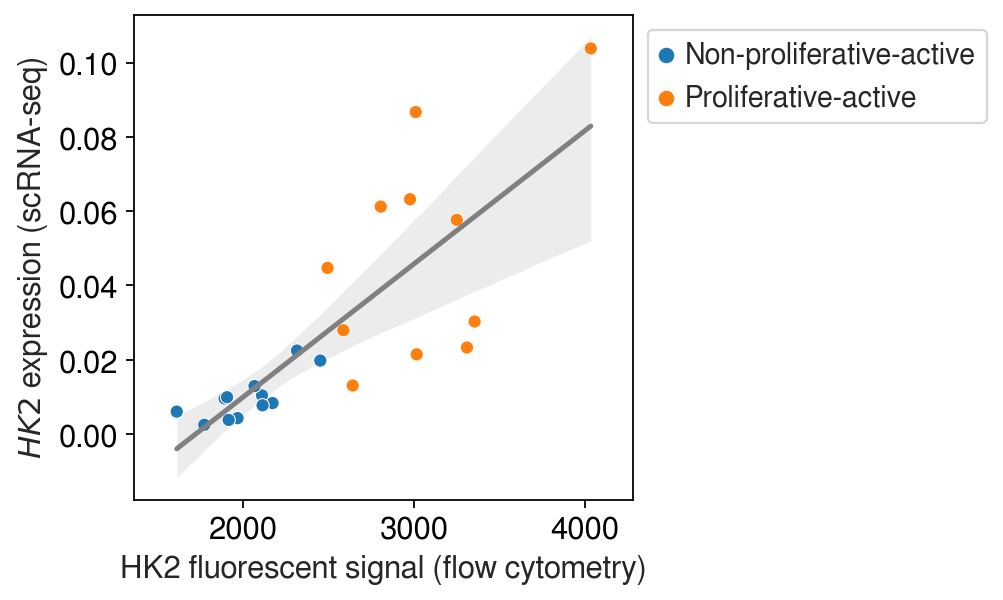

In [179]:
temp1 = flow_flow_vs_gex[['HK2 fluorescence values of KI67+ CD8s',
                   'Proliferative']]
temp1.columns = ['flow', '10X']
temp1.loc[:, 'type'] = 'Proliferative-active'

temp2 = flow_flow_vs_gex[['HK2 fluorescence values of KI67- CD8s',
                   'Non-proliferative']]
temp2.columns = ['flow', '10X']
temp2.loc[:, 'type'] = 'Non-proliferative-active'


flow_flow_vs_gex_comb = pd.concat([temp2, temp1]).dropna()

g = plt.figure(figsize=(6.5, 4))    
g = sns.regplot(data=flow_flow_vs_gex_comb.drop('142-2'), x='flow', 
            y='10X', color='gray', scatter_kws={'s':0})
g = sns.scatterplot(data=flow_flow_vs_gex_comb.drop('142-2'), x='flow', 
            y='10X', hue='type')
g.set_ylabel(r'$\itHK2$ expression (scRNA-seq)')
g.set_xlabel('HK2 fluorescent signal (flow cytometry)')
g.grid(False)
g.set_xlim(g.get_xlim()[0] - 250, g.get_xlim()[1] + 250)
print('Pearson: ' + str(pearsonr(flow_flow_vs_gex_comb.drop('142-2')['flow'], 
                                 flow_flow_vs_gex_comb.drop('142-2')['10X'])))
plt.legend( bbox_to_anchor=(1, 1) )

plt.tight_layout()
plt.savefig(master_dir + 'output/flow/cd8-flow-vs-10X_HK2-all.pdf')

In [101]:
flow_flow_vs_gex

,HK2 fluorescence values of KI67+ CD8s,HK2 fluorescence values of KI67- CD8s,Proliferative,Non-proliferative
Unnamed: 0,,,,
20-1,3310.3,2109.7,0.023289,0.010406
22-2,4035.9,2315.0,0.103808,0.022469
31-2,2805.4,2451.1,0.061231,0.019774
32-2,2493.6,1966.3,0.044722,0.004281
33-2,2976.7,1890.7,0.063214,0.009572
34-2,2641.0,1771.5,0.013061,0.002486
69-2,2586.2,1914.5,0.027948,0.003804
79-2,3242.5,2347.8,0.111783,0.011741
87-1,3355.4,2171.3,0.030290,0.008339
